#Run this piece of shit

In [1]:
pip install --upgrade torch torchvision

  Using cached torch-1.8.1-cp36-cp36m-manylinux1_x86_64.whl (804.1 MB)
ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
print(torch.__version__)
torch.manual_seed(42)

1.5.0a0+8f84ded


In [3]:
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])
def resize_image_bb(read_path,write_path,bb,sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/Path(read_path).parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

# Model

In [10]:
df = pd.read_csv('kaggle/data_after_resize (1).csv',index_col=0)
df['fullPath'] = df['fullPath'].apply(lambda x: x.replace('/content/drive/MyDrive/',''))
df['new_path'] = df['new_path'].apply(lambda x: x.replace('/content/drive/MyDrive/',''))
df['new_bb'] = df['new_bb'].apply(lambda x: np.array(eval(x.replace(".",","))))
df

,fileName,width,height,depth,xmin,ymin,xmax,ymax,label,NumeralLabel,fullPath,new_path,new_bb
0,hard_hat_workers2208.png,416,415,3,191,139,220,173,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[100, 205, 124, 236]"
1,hard_hat_workers2208.png,416,415,3,338,128,363,167,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[92, 363, 120, 390]"
2,hard_hat_workers2208.png,416,415,3,243,131,292,185,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[94, 261, 133, 313]"
3,hard_hat_workers2208.png,416,415,3,358,138,375,163,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[99, 384, 117, 402]"
4,hard_hat_workers2208.png,416,415,3,283,138,297,158,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[99, 304, 114, 319]"
5,hard_hat_workers2208.png,416,415,3,337,0,363,11,helmet,0,kaggle/images/hard_hat_workers2208.png,kaggle/resized_images/hard_hat_workers2208.png,"[0, 362, 7, 390]"
6,hard_hat_workers3374.png,416,415,3,272,182,296,209,helmet,0,kaggle/images/hard_hat_workers3374.png,kaggle/resized_images/hard_hat_workers3374.png,"[131, 292, 150, 318]"
7,hard_hat_workers3374.png,416,415,3,169,178,193,204,helmet,0,kaggle/images/hard_hat_workers3374.png,kaggle/resized_images/hard_hat_workers3374.png,"[128, 181, 147, 207]"
8,hard_hat_workers160.png,415,416,3,214,128,255,179,helmet,0,kaggle/images/hard_hat_workers160.png,kaggle/resized_images/hard_hat_workers160.png,"[92, 230, 128, 274]"
9,hard_hat_workers241.png,416,416,3,231,196,275,263,helmet,0,kaggle/images/hard_hat_workers241.png,kaggle/resized_images/hard_hat_workers241.png,"[141, 248, 189, 295]"


In [6]:
df.label.value_counts()

helmet    18966
head       5785
person      751
Name: label, dtype: int64

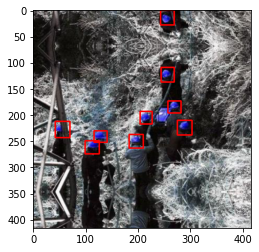

In [7]:
img = cv2.imread('kaggle/images/hard_hat_workers1.png')
for i in df[df.fileName=='hard_hat_workers1.png'].index:
  xmin = df.iloc[i]['xmin']
  ymin = df.iloc[i]['ymin']
  xmax = df.iloc[i]['xmax']
  ymax = df.iloc[i]['ymax']
  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),255,2)
plt.imshow(img)

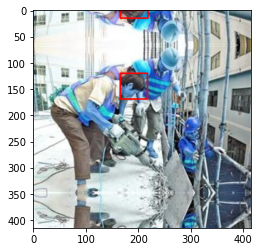

In [8]:
img = cv2.imread('kaggle/images/hard_hat_workers1005.png')
for i in df[(df.fileName=='hard_hat_workers1005.png') & (df.label == 'head')].index:
  xmin = df.iloc[i]['xmin']
  ymin = df.iloc[i]['ymin']
  xmax = df.iloc[i]['xmax']
  ymax = df.iloc[i]['ymax']
  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),255,2)
plt.imshow(img)

In [9]:
df.loc[df.label=='person'].head(2)

,fileName,width,height,depth,xmin,ymin,xmax,ymax,label,NumeralLabel,fullPath,new_path,new_bb
11,hard_hat_workers241.png,416,416,3,214,205,301,413,person,2,kaggle/images/hard_hat_workers241.png,kaggle/resized_images/hard_hat_workers241.png,"[147, 229, 297, 323]"
12,hard_hat_workers241.png,416,416,3,131,188,216,414,person,2,kaggle/images/hard_hat_workers241.png,kaggle/resized_images/hard_hat_workers241.png,"[135, 140, 298, 232]"


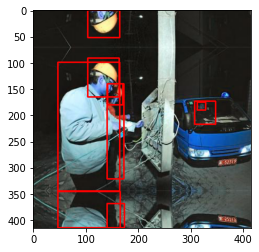

In [10]:
img = cv2.imread('kaggle/images/hard_hat_workers1007.png')
for i in df[df.fileName=='hard_hat_workers1007.png'].index:
  xmin = df.iloc[i]['xmin']
  ymin = df.iloc[i]['ymin']
  xmax = df.iloc[i]['xmax']
  ymax = df.iloc[i]['ymax']
  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),255,2)
plt.imshow(img)

In [11]:
df.drop(df.loc[df.label=='person'].index,inplace=True)

In [5]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]
def transformsXY(path,bb,tt):
  x = cv2.imread(str(path)).astype(np.float32)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
  return x,bb
class HelmetDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True,progress = False)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [11]:
df_train = df.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['NumeralLabel']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
train_ds = HelmetDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = HelmetDataset(X_val['new_path'],X_val['new_bb'],y_val)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [14]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [15]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 0.909 val_loss 0.773 val_acc 0.764
train_loss 0.734 val_loss 0.980 val_acc 0.775
train_loss 0.673 val_loss 0.939 val_acc 0.792
train_loss 0.609 val_loss 0.828 val_acc 0.781
train_loss 0.525 val_loss 0.518 val_acc 0.914
train_loss 0.493 val_loss 0.502 val_acc 0.921
train_loss 0.481 val_loss 0.461 val_acc 0.933
train_loss 0.465 val_loss 0.443 val_acc 0.934
train_loss 0.446 val_loss 0.499 val_acc 0.910
train_loss 0.434 val_loss 0.453 val_acc 0.932
train_loss 0.420 val_loss 0.457 val_acc 0.924
train_loss 0.412 val_loss 0.418 val_acc 0.937
train_loss 0.408 val_loss 0.425 val_acc 0.934
train_loss 0.403 val_loss 0.413 val_acc 0.939
train_loss 0.396 val_loss 0.412 val_acc 0.938


0.39639481438530816

In [16]:
torch.save(model.state_dict(), 'helmet_detection.pth')

In [88]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bbs):
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))
    

In [6]:
model = BB_model()

In [7]:
model.load_state_dict(torch.load('helmet_detection.pth'))
model.eval()

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [93]:
X_val.sample()

,new_path,new_bb
15686,kaggle/resized_images/hard_hat_workers2398.png,"[99, 134, 124, 162]"


In [120]:
path = "hard_hat_workers1007.png"
im = read_image("kaggle/resized_images/"+path)
im = cv2.resize(im, (int(1.49*224), 224))
cv2.imwrite('kaggle/test/'+path, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
# test Dataset
test_ds = HelmetDataset(pd.DataFrame([{'path':'kaggle/test/'+path}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]
xx = torch.FloatTensor(x)[None,]
print(xx.shape) 

torch.Size([1, 3, 224, 333])


In [121]:
# prediction
out_class, out_bb = model(xx.cpu())
print(out_class, out_bb)

tensor([[ 1.6826, -1.6040]], grad_fn=<AddmmBackward>) tensor([[ 69.9750, 177.5700, 117.5773, 238.0417]], grad_fn=<AddmmBackward>)


In [122]:
# predicted class
print(torch.max(out_class, 1))

torch.return_types.max(
values=tensor([1.6826], grad_fn=<MaxBackward0>),
indices=tensor([0]))


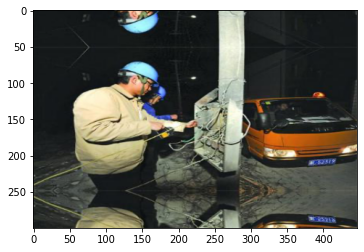

In [123]:
#Original Image
im = read_image('kaggle/resized_images/'+path)
plt.imshow(im)

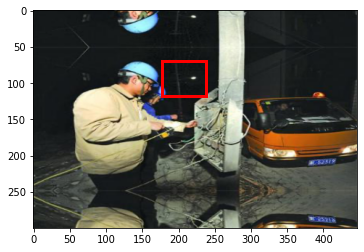

In [125]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat)

(300, 447, 3)


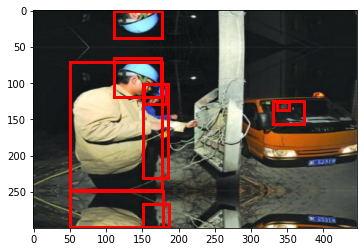

In [126]:
# Actual Bounding
im = read_image('kaggle/resized_images/'+path)
print(im.shape)
original_bbs = df[df['new_path']=='kaggle/resized_images/'+path].index.to_list()
show_corner_bb(im,df.new_bb[original_bbs])